In [34]:
import wandb
from src.data import DataModule
from src.config import radiomics_folder, lesion_level_labels_csv


wandb.init()
wandb.config.roi_selection_method = "crop"
wandb.config.aggregation_function = "min"
wandb.config.roi_size = 71
wandb.config.optimizer = "adamw"
wandb.config.weight_decay = 0.00001
wandb.config.model = "SEResNet50"
wandb.config.dropout = 0.07292136035956572
wandb.config.momentum = 0
wandb.config.pretrained = False
wandb.config.learning_rate_max = 0.000023059510738335888
wandb.config.sampler = "label_organ_stratified"
wandb.config.dim = 3
wandb.config.size = 182 if wandb.config.dim == 3 else 256
wandb.config.test_center = None  # "amphia"
wandb.config.lesion_target = "lesion_response"
wandb.config.patient_target = "response"
wandb.config.max_batch_size = 6 if wandb.config.dim == 3 else 32
wandb.config.seed = 0
wandb.config.max_epochs = 100
wandb.config.patience = 10
wandb.config.lr_min = 1e-7
wandb.config.T_0 = 10
wandb.config.augmentation_noise_std = 0.001
wandb.config.inner_fold= 0


dm = DataModule(
    radiomics_folder,
    lesion_level_labels_csv,
    wandb.config,
)

dm.setup()

In [36]:
train_patients = [x['patient'] for x in dm.train_data]
val_patients = [x['patient'] for x in dm.val_data]

In [40]:
len(val_patients)

568

In [9]:
import numpy as np
import random 

all_patients = np.unique([x['patient'] for x in dm.train_data])
random.shuffle(all_patients)

In [30]:
import pandas as pd

df = pd.read_csv(lesion_level_labels_csv, sep=';')

In [33]:
df.groupby('patient').fold.first()

patient
IM_001     1
IM_002     3
IM_004     2
IM_012     0
IM_013     4
          ..
UNI_186    2
UNI_191    0
UNI_206    4
UNI_219    2
UNI_220    0
Name: fold, Length: 731, dtype: int64

In [18]:
patients = df.patient.unique()

In [20]:
random.shuffle(patients)

In [27]:
fold_assigment_dict = dict(zip(patients, np.arange(len(patients)) % 5))

fold = []
for patient in df.patient:
    fold.append(fold_assigment_dict[patient])

df['fold'] = fold

In [29]:
df.to_csv(lesion_level_labels_csv, sep=';')

In [36]:
import numpy as np
from monai.data import Dataset
from monai.transforms import (
    Compose, 
    LoadImaged, 
    EnsureChannelFirstd, 
    RandRotated, 
    CenterSpatialCropd,
    RandGaussianNoised,
    SaveImaged
)
from torch.utils.data import DataLoader

data = dm.train_data

t = Compose([
    LoadImaged(keys=['img']),
    EnsureChannelFirstd(keys=['img']),
    RandRotated(
        keys=['img'], 
        range_x=(0,2*np.pi), 
        range_y = (0,2*np.pi), 
        range_z=(0,2*np.pi), 
        prob=1
    ),
    CenterSpatialCropd(keys=['img'], roi_size=(128,128,128)),
    RandGaussianNoised(keys=['img'], prob=1, std=0.001),
    # SaveImaged(
    #     keys=['img'], 
    #     output_dir='/mnt/c/Users/user/data/dl_radiomics/augmented', 
    #     output_ext='.nii.gz',
    #     resample=False,
    #     separate_folder=False,
    # )
])

ds = Dataset(data, t)
dl = DataLoader(ds, batch_size=6)

x = next(iter(dl))

In [37]:
x['img'].shape

(6, 1, 128, 128, 128)

In [25]:
import pandas as pd

df = pd.read_csv("/mnt/c/Users/user/data/tables/lesion_followup_curated_master.csv", sep=';')

In [29]:
len(df)

2772

In [8]:
import pandas as pd

df = pd.read_csv('/mnt/c/Users/user/Downloads/wandb_export_2023-01-20T08_15_03.480+01_00.csv')
df = df[df.State == 'finished']

In [9]:
df.columns

Index(['Name', 'Agent', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime',
       'Sweep', 'T_0', 'aggregation_function', 'dim', 'dropout',
       'learning_rate_max', 'lesion_target', 'lr_min', 'max_batch_size',
       'max_epochs', 'model', 'n_forward_per_backwards', 'optimizer',
       'patience', 'patient_target', 'pretrained', 'roi_selection_method',
       'roi_size', 'sampler', 'seed', 'size', 'weight_decay', 'epoch', 'lr',
       'train_auc', 'train_loss', 'train_patient_auc', 'trainer/global_step',
       'valid_auc', 'valid_loss', 'valid_patient_auc'],
      dtype='object')

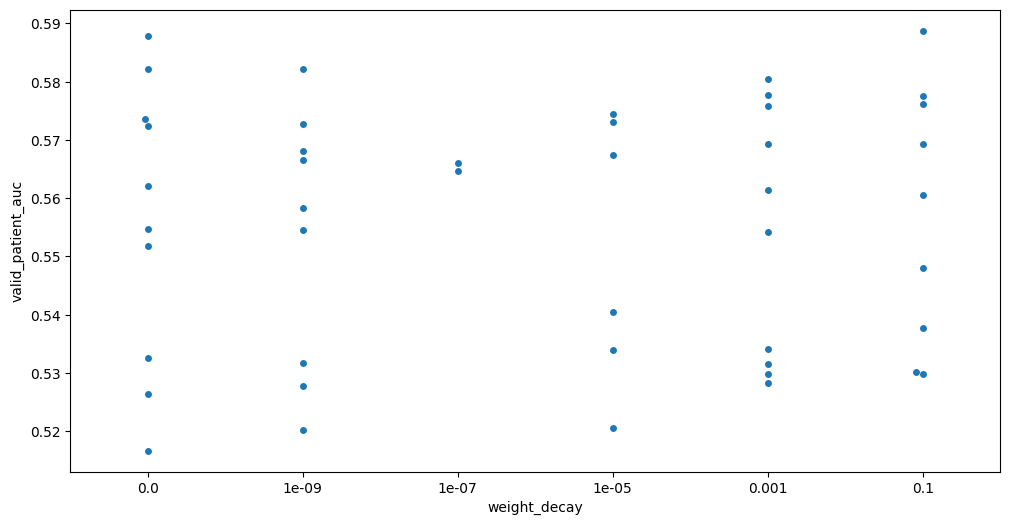

In [10]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(12,6))
sn.swarmplot(data=df, x='weight_decay', y='valid_patient_auc')
plt.show()

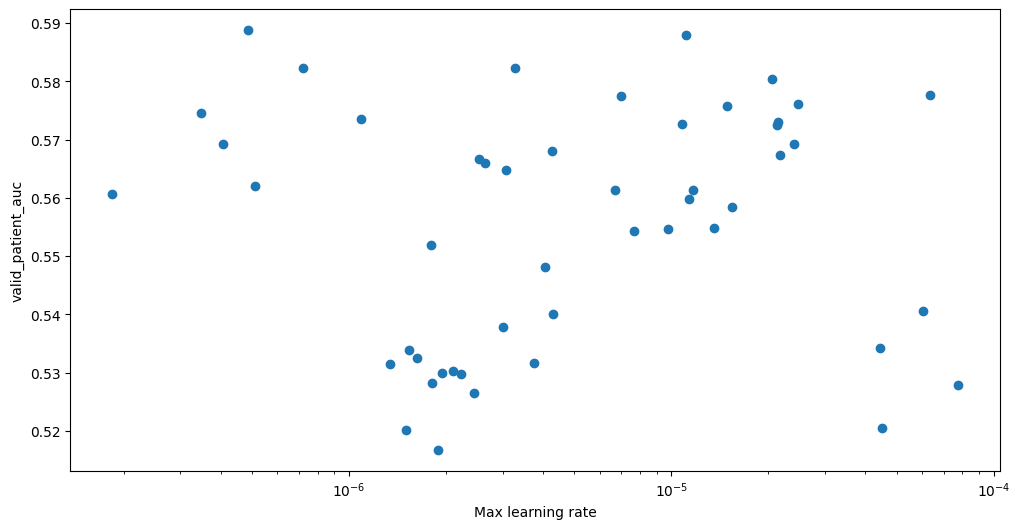

In [22]:
plt.figure(figsize=(12,6))
plt.scatter(df.lr, df.valid_patient_auc)
plt.xlabel('Max learning rate')
plt.ylabel('valid_patient_auc')
plt.xscale('log')
plt.show()

In [48]:
batch = np.array(list(range(32)))


mini_batch_size =32
for ix in range(0, len(batch), mini_batch_size):
    print(batch[ix:ix+mini_batch_size])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


In [50]:
len(x)

32

In [23]:
new_grad[0,0,0]

array([-9.4738527e-05, -1.0190648e-04, -1.3707948e-04, -1.4512578e-04,
       -1.3249271e-04, -5.2837066e-05, -3.5660356e-05], dtype=float32)

In [24]:
original_grad[0,0,0]

array([-9.4678675e-05, -1.0183325e-04, -1.3698640e-04, -1.4505384e-04,
       -1.3245209e-04, -5.2787924e-05, -3.5580433e-05], dtype=float32)

In [21]:
y_hat.detach().numpy()

array([[0.34611627],
       [0.34112442],
       [0.40652257],
       [0.39151615],
       [0.3430734 ],
       [0.3531861 ]], dtype=float32)

In [22]:
y_hat2.detach().numpy()

array([[0.34611627],
       [0.34112436],
       [0.4065227 ],
       [0.39151615],
       [0.34307343],
       [0.35318622]], dtype=float32)

In [35]:
from pathlib import Path
import numpy as np

dl = dm.val_dataloader()

batches = []
for batch in dl:
    batches.append(np.stack([
        batch['label'].numpy(),
        batch['organ'],
        [Path(f).name for f in batch['img_meta_dict']['filename_or_obj']]
    ], axis=1))

Loading dataset: 100%|██████████| 576/576 [00:00<00:00, 550072.66it/s]


In [32]:
possible = [case['img'].split('/')[-1] for case in dm.train_data]

In [20]:
batch['organ']

['adrenal',
 'bone',
 'liver',
 'liver',
 'liver',
 'lung',
 'lung',
 'lung',
 'lymph',
 'lymph',
 'lymph',
 'lymph',
 'other',
 'abdomen',
 'abdomen',
 'bone',
 'liver',
 'lung',
 'lung',
 'lung',
 'lung',
 'lung',
 'lung',
 'lung',
 'lymph',
 'lymph',
 'lymph',
 'lymph',
 'lymph',
 'other',
 'subcutis',
 'subcutis']

In [5]:
from src.config import lesion_level_labels_csv, dmtr_csv
import pandas as pd

dmtr = pd.read_csv(dmtr_csv)
lesion_fu = pd.read_csv(lesion_level_labels_csv, sep=';')

/tmp/ipykernel_19073/2195945971.py:4: DtypeWarning: Columns (27,29,175,234,249,259,275,281,313,318,351,393,440,538,547,550,578,585,591,654,660,662,663,664,666,667,669,670,671,676,677,679,680,681,682,685,794,797,805,808,809,818,819,821,822,823,828,851,852,854,855,856,863,864,866,867,868,869,870,872,873,874,875,876,878,879,880,881,882,884,885,886,899,900,902,903,904,905,906,908,909,910,911,912,914,915,916,917,918,920,921,922,924) have mixed types. Specify dtype option on import or set low_memory=False.
  dmtr = pd.read_csv(dmtr_csv)


In [11]:
import numpy as np

np.unique([pt for pt in lesion_fu.patient if not pt in dmtr.id.values])

array(['UMCG_118', 'UMCG_382', 'UMCG_400', 'UMCG_448', 'UMCG_457',
       'UMCG_469', 'UMCG_548', 'UMCG_650'], dtype='<U8')

In [12]:
umcg = pd.read_excel('/mnt/c/Users/user/repos/PREMIUM/code/radiomics_paper/data/raw_dmtr/umcg.xlsx')

In [24]:
umcg[umcg.upn == 'UMCG_656'].ptloc

26385    1.0
26386    1.0
26387    1.0
26388    1.0
26389    1.0
        ... 
26836    1.0
26837    1.0
26838    1.0
26839    1.0
26840    1.0
Name: ptloc, Length: 456, dtype: float64

In [53]:
import pandas as pd

df = pd.read_csv("/mnt/d/premium_data/umcg/umcg_followup (1).csv", sep=';')

In [55]:
df['delta1'] = df['fu1'] / df['baseline']
df['delta2'] = df['fu2'] / df['baseline']
df['delta3'] = df['fu3'] / df['baseline']

In [63]:
last_fus = []
for _, lesion in df.iterrows():
    last_fu = float('nan')
    if not pd.isna(lesion.delta1):
        last_fu = lesion.delta1
    if not pd.isna(lesion.delta2):
        last_fu = lesion.delta2
    if not pd.isna(lesion.delta3):
        last_fu = lesion.delta3
    last_fus.append(last_fu)

df['last_fu'] = last_fus

In [67]:
lesion_response, lesion_benefit = [],[]
for _, lesion in df.iterrows():
    if pd.isna(lesion.last_fu):
        lesion_response.append(float('nan'))
        lesion_benefit.append(float('nan'))
        continue

    if lesion.last_fu < 0.7:
        lesion_response.append(1)
    else: 
        lesion_response.append(0)

    if lesion.last_fu < 1.2:
        lesion_benefit.append(1)
    else: 
        lesion_benefit.append(0)

df['lesion_response'] = lesion_response
df['lesion_benefit'] = lesion_benefit

In [68]:
df

,lesion,name,patient,start_date,scan_date,baseline,fu1,fu2,fu3,delta1,delta2,delta3,last_fu,lesion_response,lesion_benefit
0,UMCG_004abdomen_0.nii.gz,softtissue1,UMCG_004,17-10-2016,30-9-2016,97.0,85.0,NaN,NaN,0.876289,NaN,NaN,0.876289,0.0,1.0
1,UMCG_004abdomen_1.nii.gz,lymph1,UMCG_004,17-10-2016,30-9-2016,20.0,16.0,NaN,NaN,0.800000,NaN,NaN,0.800000,0.0,1.0
2,UMCG_004abdomen_2.nii.gz,lymph2,UMCG_004,17-10-2016,30-9-2016,27.0,49.0,NaN,NaN,1.814815,NaN,NaN,1.814815,0.0,0.0
3,UMCG_004thorax_0.nii.gz,lung1,UMCG_004,17-10-2016,30-9-2016,29.0,32.0,NaN,NaN,1.103448,NaN,NaN,1.103448,0.0,1.0
4,UMCG_004thorax_1.nii.gz,lymph1,UMCG_004,17-10-2016,30-9-2016,44.0,11.0,NaN,NaN,0.250000,NaN,NaN,0.250000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,UMCG_738abdomen_0.nii.gz,subcutis1,UMCG_738,11-4-2017,15-3-2017,10.0,13.0,12.0,9.0,1.300000,1.200000,0.900,0.900000,0.0,1.0
459,UMCG_738abdomen_1.nii.gz,lymph1,UMCG_738,11-4-2017,15-3-2017,21.0,21.0,0.0,NaN,1.000000,0.000000,NaN,0.000000,1.0,1.0
460,UMCG_738abdomen_2.nii.gz,lymph2,UMCG_738,11-4-2017,15-3-2017,19.0,18.0,0.0,NaN,0.947368,0.000000,NaN,0.000000,1.0,1.0
461,UMCG_738abdomen_3.nii.gz,subcutis2,UMCG_738,11-4-2017,15-3-2017,8.0,7.0,6.0,5.0,0.875000,0.750000,0.625,0.625000,1.0,1.0


In [69]:
organ_synonyms = {
    'lung':['lung','pleur','pulm'],
    'liver':['liver'],
    'lymph':['lymph', 'lymoh', 'inguin', 'supraclav'],
    'subcutis':['subcut'],
    'adrenal':['adren'],
    'abdomen':['abd', 'mesent', 'intest', 'perit','mesent','adbom'],
    'bone':['bone', 'os', 'th5', 'ileum'],
    'spleen':['spleen']
}

organs = []
for name in df['name'].tolist():
    name = name.lower()

    found = False
    for organ, synonyms in organ_synonyms.items():
        if any([synonym in name for synonym in synonyms]):
            organs.append(organ)
            found = True
            break

    if not found:
        organs.append('other')
        
df['organ'] = organs

In [71]:
df.to_csv('/mnt/d/premium_data/umcg/lesion_followup_curated.csv')

In [38]:
df.drop(columns=['Unnamed: 0']).to_csv("/mnt/c/Users/user/data/tables/lesion_followup_curated_master.csv")

In [24]:
val_dl = dm.val_dataloader()

val_batches = []
for batch in val_dl:
    val_batches.append(
        list(zip(batch['patient'], batch['label'].numpy().tolist()))
    )

Loading dataset: 100%|██████████| 568/568 [00:00<00:00, 596485.90it/s]


In [43]:
from collections import defaultdict

def count_per_patient(batches):
    count = defaultdict(int)
    for batch in batches:
        for case in batch:
            count[case[0]] += 1

    assert max(list(count.values())) <= 5

def no_overlap(train, val):
    train_patients = set()
    for batch in train:
        for case in batch:
            train_patients.add(case[0])

    val_patients = set()
    for batch in val:
        for case in batch:
            val_patients.add(case[0])

    assert train_patients.isdisjoint(val_patients)

count_per_patient(batches)
no_overlap(batches, val_batches)